# Decision tree 

### Concepts:
- Decision Trees are a kind of **non-parametric** models - this means that Decision trees are flexible models that don’t increase their number of parameters as we add more features.
- Nodes:
  - Root Node: Is the node that starts the graph. In a normal decision tree it evaluates the variable that best splits the data.
  - Splitting: The process of dividing a node into multiple sub-nodes.
  - Decision node: When a sub-node is further split into additional sub-nodes.
  - Leaf nodes: These are the final nodes of the tree, where the predictions of a category or a numerical value are made.
  - Pruning: The process of removing sub-nodes of a decision tree.
  - Branch: A subsection of the decision tree consisting of multiple nodes.
- Gini index or the Entropy for categorical decision trees
- Residual or Mean Squared Error for regression trees.

### Types of learning algorithms 

- ID3 (Iterative Dichotomiser 3)
- C4.5 (successor of ID3)
- CART (Classification And Regression Tree)
- Chi-square automatic interaction detection (CHAID). Performs multi-level splits when computing classification trees.
- MARS: extends decision trees to handle numerical data better.
- Conditional Inference Trees. Statistics-based approach that uses non-parametric tests as splitting criteria, corrected for multiple testing to avoid overfitting. This approach results in unbiased predictor selection and does not require pruning


#### Entropy 

measure of $H(S)$ is a measure of the amount of uncertainty in the (data) set S

$$ H(S) = \sum _{x \in X} -p(x) log_{2} p(x) $$

Where,

S – The current dataset for which entropy is being calculated
This changes at each step of the ID3 algorithm, either to a subset of the previous set in the case of splitting on an attribute or to a "sibling" partition of the parent in case the recursion terminated previously.

X – The set of classes in S 

p(x) – The proportion of the number of elements in class x to the number of elements in set S


#### Information gain 
$$IG(S, A) = H(S) - \sum _{t \in T} p(t) H (t) = H(S) - H(S|A)$$

Where,

H(S) Entropy of set 

T – The subsets created from splitting set S by attribute A

p(t)} – The proportion of the number of elements in t to the number of elements in set S

H(t) – Entropy of subset t


#### Split information 

$$SplitInformation (X) = - \sum _{i =1} ^{n} \frac{N(x_{i})}{N(x)} * log_{2} \frac{N(x_{i})}{N(x)} $$

where X is a **discrete** random variable with possible values $x_{1}, x_{2}, ... x_{i}$ and $N(x_{i})$ being the number of times that $x_{i}$ occurs divided by the total count of events  $N(x)$ where x is the set of events.

For **continuous** data C4.5 uses a threshold value where everything less than the threshold is in the left node, and everything greater than the threshold goes in the right node. The question is how to create that threshold value from the data you're given. The trick there is to sort your data by the continuous variable in ascending order. Then iterate over the data picking a threshold between data members. 


#### Information gain ratio 

$$IGR (T, a) = \frac{IG (T, a)} {SplitInformation(T)} $$

$$IGR (T, a) = \frac{- \sum_{i=1}^{n} P(T) logP(T) - (-\sum_{i=1}^{n} P(T|a) logP(T|a))} {- \sum _{i =1} ^{n} \frac{N(t_{i})}{N(t)} * log_{2} \frac{N(t_{i})}{N(t)}} $$ 



Pen & paper example: 
https://medium.com/@sumit-kr-sharma/understanding-c4-5-decision-tree-algorithm-3bf0981faf4f

#### Pseudocode C4.5

Base cases:

- All the samples in the list belong to the same class. When this happens, it simply creates a leaf node for the decision tree saying to choose that class.
- None of the features provide any information gain. In this case, C4.5 creates a decision node higher up the tree using the expected value of the class.
- Instance of previously unseen class encountered. Again, C4.5 creates a decision node higher up the tree using the expected value.

In pseudocode, the general algorithm for building decision trees is:

1. Check for the above *base cases*.
2. For each attribute a, find the normalized information gain ratio from splitting on a.
3. Let *a_best* be the attribute with the highest normalized information gain.
4. Create a decision *node* that splits on *a_best*.
5. Recurse on the sublists obtained by splitting on *a_best*, and add those nodes as children of *node*.

### Gini impurity 

CART uses Gini impurity instead of entropy / information gain as a way to split the node. 

For a binary classification problem with two classes (let's call them Class A and Class B), the Gini impurity for a set S is calculated as follows:

$$Gini (S) = 1 - \sum _{i = 1} ^ {n} p_{i}^{2}$$
A Gini score gives an idea of how good a split is by how mixed the response classes are in the groups created by the split. 


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [27]:
import logging 
import numpy as np 
import pandas as pd
import sklearn 
import algo_ecg.data
import algo_ecg.preprocessing

from algo_ecg.feature_transformer import \
    FindPeaksCustomTransformer, select_cols, \
    AllFeatureCustomTransformer, \
    functional_return_all_features


from algo_ecg.decision_tree_entropy import C45DecisionTree
#import algo_ecg.decision_tree_gini.C45DecisionTree

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
import sklearn.model_selection
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score

#from sklearn import tree

from sklearn.tree import plot_tree, export_text, DecisionTreeClassifier


In [2]:
X_in, y = algo_ecg.data.import_physionet_data('../data', num_files_to_read=1000)
X = algo_ecg.preprocessing.preprocess(X_in)

In [3]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=.7)

In [4]:
slice_length = len(X_train[0])
X_train = np.concatenate(X_train).reshape(-1, slice_length, 1)
X_test = np.concatenate(X_test).reshape(-1, slice_length, 1)

In [5]:
X_train_pd = pd.DataFrame.from_records(X_train)
X_test_pd = pd.DataFrame.from_records(X_test)
                 

In [6]:
pipe = Pipeline(steps=[
#    ('peaks', FindPeaksCustomTransformer (axis=1)), 
    ('features_all',AllFeatureCustomTransformer(axis = 1)), 
#    ('feature_select_manual',FunctionTransformer(select_cols, kw_args={"col_names": ['pNN50','RMSSD_ms']})),
    ('standardscaler', StandardScaler())
])


In [7]:
X_train_pd_transform = pipe.fit_transform(X_train_pd)
X_test_pd_transform = pipe.fit_transform(X_test_pd)

In [8]:
clf_tree = C45DecisionTree(max_depth=5, min_samples_split=1)
clf_tree.fit(X_train_pd_transform, y_train)


In [50]:
prediction = clf_tree.predict(X_test_pd_transform)

#print("Prediction:", prediction)
print("Accuracy:", accuracy_score(prediction, y_test))


Accuracy: 0.9134615384615384


#### Visualisation

In [9]:
tree_text = clf_tree.export_tree_text()

In [10]:
print(tree_text)

if feature 9 <= 1.373720886164267:
  if feature 11 <= 0.4210973498471406:
    if feature 1 <= -1.430550528565762:
      Class: 1
    else:
      if feature 19 <= 2.0591254077916474:
        if feature 18 <= -0.9664101220000174:
          Class: 0
        else:
          Class: 0
      else:
        if feature 0 <= 0.7462378197704628:
          Class: 0
        else:
          Class: 1
  else:
    if feature 7 <= 1.1151133323222018:
      if feature 7 <= -0.04871760341329666:
        Class: 0
      else:
        if feature 7 <= 0.07291134515885012:
          Class: 1
        else:
          Class: 0
    else:
      Class: 0
else:
  if feature 0 <= -1.2634968233327921:
    if feature 5 <= -0.13081221295533796:
      Class: 0
    else:
      if feature 0 <= -1.2721909513960532:
        Class: 1
      else:
        Class: 0
  else:
    if feature 1 <= 1.6408519474443182:
      if feature 11 <= 2.361788157927934:
        Class: 1
      else:
        if feature 1 <= 1.1121517306892204:
     

In [51]:
#### Compare this with the sklearn implementation

In [53]:
sklearn_dt = DecisionTreeClassifier(max_depth=5, criterion = "entropy")
sklearn_dt.fit(X_train_pd_transform, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [54]:
prediction = sklearn_dt.predict(X_test_pd_transform)
#print("Prediction:", prediction)
print("Accuracy:", accuracy_score(prediction, y_test))


Accuracy: 0.9182692307692307


In [55]:
feature_names = ['Mean_RR_ms','STD_RR_ms', 'Mean_HR_beats_per_min_kubio', 'Mean_HR_beats_per_min', \
'STD_HR_beats_per_min', 'Min_HR_beats_per_min', 'Max_HR_beats_per_min', 'RMSSD_ms',\
'NN50', 'pNN50', 'NN70', 'pNN70', 'Power_VLF_ms2', 'Power_LF_ms2', 'Power_HF_ms2', \
'Power_Total_ms2', 'LF_HF_ratio', 'Peak_VLF_Hz', 'Peak_LF_Hz', 'Peak_HF_Hz', \
'Fraction_LF_nu', 'Fraction_HF_nu']

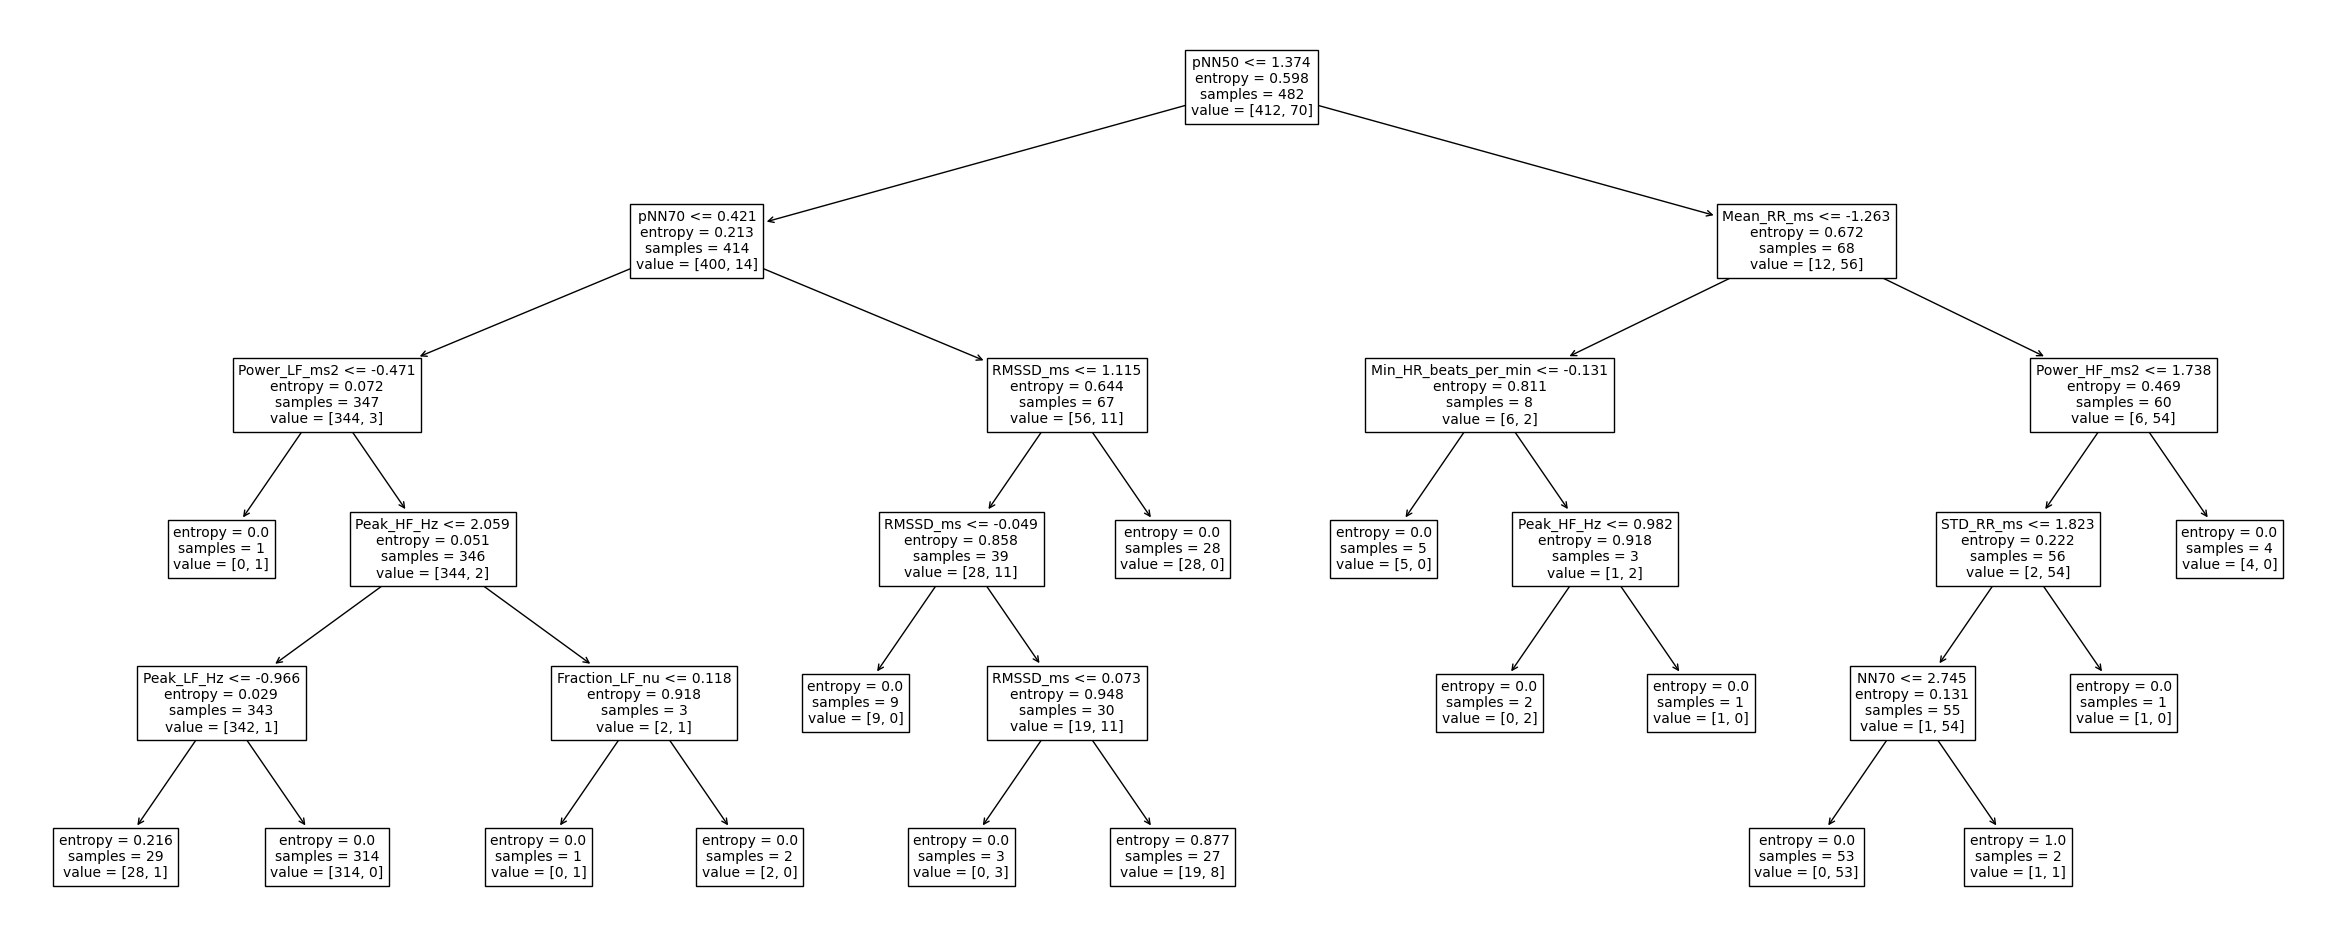

In [56]:
plt.figure(figsize=(30,12)) 
plot_tree(sklearn_dt, feature_names = feature_names, fontsize=10)
#plt.show()
plt.savefig('tree_high_dpi', dpi=100)
